# MMAI831 Manheim Recommender Engine

GitHub: https://github.com/PentheusLennuye/mmai831/blob/main/emc/mmai831_watts_emc.ipynb

The first iteration of an unsupervised clustering algorithm that will produce
lists of likely vehicles that given wholesalers will purchase from auctions.

## CAVEAT

The CSV file referred to in cell 2 (cox_vehicle_info.csv) is proprietary and
sensitive to Manheim Canada. It is not available to the assessors of this code by
default.

Running this code will not work without the file. Please apply to Watts.

In [1]:
import os
import re

import matplotlib.pyplot as plt
import tqdm 

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from statsmodels.graphics.gofplots import qqplot

SCRIPT_DIR = os.path.abspath('')

In [2]:
# Globals
CSVFILE = 'cox_vehicle_info.csv'
TEST_SPLIT = 25  # in percent. Not required for unsupervised learning.
RANDOM_STATE = 42  # Life, the Universe and Everything

In [3]:
# Classes

def BadOperationError(Exception):
    """Operator is not programmed for"""

# Functions =================

def load_data(filename: str)-> pd.DataFrame:
    """Loads a CSV and returns a full dataframe"""
    return pd.read_csv(
        os.path.join(SCRIPT_DIR, filename),
        dtype={
            'Buyer_Account': 'str'
        }
    )

def clean_column_names(df:pd.DataFrame):
    """Convert to snake-case inplace"""
    repl = lambda m: m.group(1) + re.sub(r'([A-Z])', r'_\1', m.group(2)) 
    columns = df.columns.str.replace(
        r'(^[A-Z])(\w+)', repl, regex=True
    )
    columns = columns.str.replace('__', '_')
    columns = columns.str.lower()
    df.columns = columns

    
def sanitize(df:pd.DataFrame, sane_values:list)->pd.DataFrame:
    """Drop NaN rows as well as rows outside sane values"""
    jump = {
        '<': _high_pass_filter,
        '>': _low_pass_filter,
        '><': _mid_pass_filter,
        '!': _drop_column
    }
    df_clean = df.copy()
    
    df_clean = df_clean.dropna()
    for feature, operation, values in sane_values:
        if operation in jump:
            jump[operation](df_clean, feature, values) 
        else:
            raise BadOperationError
    
    return df_clean


def clean_features(df:pd.DataFrame, features:list[str])->pd.DataFrame:
    """Ensure all colours (for example) are standardized """
    df_clean = df.copy()
    for feature in features:
        df_clean[feature] = df_clean[feature].str.lower()
        df_clean[feature] = df_clean[feature].str.replace(
            '[^0-9a-zA-Z]*$', '', regex=True
        )
    return df_clean
           
def _low_pass_filter(df:pd.DataFrame, feature, values):
    df.drop(df[df[feature] < values[0]].index, inplace=True)
    

def _high_pass_filter(df:pd.DataFrame, feature, values):
    df.drop(df[df[feature] > values[0]].index, inplace=True)
    

def _mid_pass_filter(df:pd.DataFrame, feature, values):
    mask = (df[feature] < values[0]) | (df[feature] > values[1])
    df.drop(df[mask].index, inplace=True)
    
def _drop_column(df:pd.DataFrame, feature, values=0):
    df.drop([feature], axis=1, inplace=True)


def create_unsupervised_dataframe(
    clean_df: pd.DataFrame,
    onehotcolumns: list[str])->list[pd.DataFrame, OneHotEncoder]:
    """Ensure all features required for unsupervised learning are in the
       dataframe and return the fitted one hot encoder."""
    onehot = OneHotEncoder(dtype='int32')

    new_df = pd.DataFrame(
        onehot.fit_transform(clean_df[onehotcolumns]).toarray()
    )
    new_df.columns = onehot.get_feature_names_out()
    
    return new_df, onehot


def create_prediction_dataframe(
    clean_df: pd.DataFrame,
    onehot: OneHotEncoder,
    onehotcolumns: list[str])->pd.DataFrame:
    """Create a dataframe to be fed into an already trained model, using an
       already-trained OneHotEncoder"""
    
    new_df = pd.DataFrame(
        onehot.transform(clean_df[onehotcolumns]).toarray()
    )
    new_df.columns = onehot.get_feature_names_out()
    return new_df


def combine_outliers(
    data:pd.DataFrame,
    feature:str,
    threshold:int)->list[pd.DataFrame, list]:
    """Rename any value whose count is smaller than a percentage of the most
    popular value with 'other'. Returns the new dataset and a list of values
    that were merged"""
    df_working = data.copy()
    value_counts = df_working[feature].value_counts()
    top_count = df_working[feature].value_counts().max()
    num_counts = len(value_counts)
    altered_values = []

    for count in range(num_counts):
        if ((value_counts[count] / top_count) * 100) < 5:  # percent
            colour = value_counts.index[count]
            altered_values.append(colour)
            df_working[feature].replace(colour, 'other', inplace=True)

    return df_working, altered_values

## Data import

In [4]:
df_raw = load_data(CSVFILE)
df_raw.columns
clean_column_names(df_raw)
df_raw = df_raw.rename(columns={'clientt_type': 'client_type'})
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643053 entries, 0 to 643052
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   sale_listing_id                643053 non-null  int64  
 1   sale_id                        643053 non-null  int64  
 2   sale_number                    643053 non-null  int64  
 3   sale_date                      643053 non-null  object 
 4   sale_week                      643053 non-null  int64  
 5   sale_year                      643053 non-null  int64  
 6   lane_number                    643053 non-null  int64  
 7   branch_id                      643053 non-null  int64  
 8   client_type                    643053 non-null  object 
 9   seller_account                 643053 non-null  object 
 10  buyer_account                  643044 non-null  object 
 11  sold_price                     643053 non-null  int64  
 12  drive_type_description        

In [5]:
df_raw[['branch_id']].value_counts()

branch_id
1            403725
2            108058
3             70145
4             58614
5              2498
10007            13
dtype: int64

In [6]:
df_raw[['base_colour']].value_counts()

base_colour
Black          161553
White          154643
Gray           105351
Silver          63508
Blue            58681
                ...  
SKID 15             1
SILVER 1            1
CARIBOO             1
CHAMPAGN            1
silver              1
Length: 292, dtype: int64

## Feature Selection
From previous experiments, we select base colour, body type description, engine
description, price range and drive type description.

# B. Outlier Removal
Required to deal with poor cluster separation

In [7]:
SANITIZE_DATA = [
    ('branch_id', '<', [5,]),  # Under 5 is correct
#    ('sold_price', '<', [200000,]),  # Outliers (above) more sophisticated
    ('odometer_value', '><', [50, 420000])
]
df_clean = sanitize(df_raw, SANITIZE_DATA)
df_clean = clean_features(df_clean, ['base_colour'])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 409287 entries, 143 to 643052
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   sale_listing_id                409287 non-null  int64  
 1   sale_id                        409287 non-null  int64  
 2   sale_number                    409287 non-null  int64  
 3   sale_date                      409287 non-null  object 
 4   sale_week                      409287 non-null  int64  
 5   sale_year                      409287 non-null  int64  
 6   lane_number                    409287 non-null  int64  
 7   branch_id                      409287 non-null  int64  
 8   client_type                    409287 non-null  object 
 9   seller_account                 409287 non-null  object 
 10  buyer_account                  409287 non-null  object 
 11  sold_price                     409287 non-null  int64  
 12  drive_type_description      

## Sold Price

In [8]:
df_raw.shape

(643053, 25)

In [9]:
df_raw.describe()

,sale_listing_id,sale_id,sale_number,sale_week,sale_year,lane_number,branch_id,sold_price,vehicle_id,year,odometer_value
count,6.430530e+05,643053.000000,643053.000000,643053.000000,643053.000000,643053.000000,643053.000000,643053.000000,643053.000000,642614.000000,642758.000000
mean,7.922757e+05,12129.184008,428.437235,25.205635,2013.499304,20.156580,1.877470,19557.072548,320286.913743,2014.880102,102902.099022
std,2.141634e+05,2427.988005,212.805491,14.797094,117.705763,29.304903,44.997256,18256.669252,122908.169806,4.771206,78473.710745
min,1.100000e+01,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,43.000000,0.000000,0.000000
25%,7.468950e+05,11368.000000,294.000000,13.000000,2020.000000,2.000000,1.000000,5100.000000,266261.000000,2012.000000,37451.000000
50%,8.411020e+05,12405.000000,450.000000,23.000000,2020.000000,6.000000,1.000000,15200.000000,346344.000000,2016.000000,87115.000000
75%,9.478580e+05,13642.000000,589.000000,38.000000,2021.000000,25.000000,2.000000,29300.000000,426158.000000,2018.000000,154608.000000
max,1.017571e+06,14171.000000,763.000000,61.000000,2022.000000,99.000000,10007.000000,529000.000000,459787.000000,2022.000000,999999.000000


<AxesSubplot:ylabel='sold_price'>

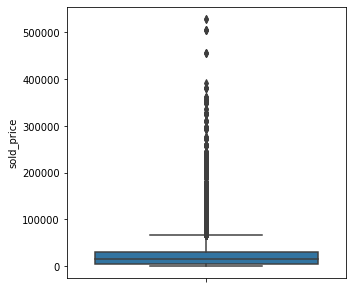

In [10]:
plt.figure(figsize=(5,5))
sns.boxplot(y='sold_price',data=df_raw)

## Sold Price Outlier detection by percentage

In [8]:
min_thresold, max_thresold = df_raw.sold_price.quantile([0.05, 0.95])
min_thresold, max_thresold

(1000.0, 51400.0)

In [12]:
df_raw[df_raw.sold_price < min_thresold]

,sale_listing_id,sale_id,sale_number,sale_date,sale_week,sale_year,lane_number,branch_id,client_type,seller_account,...,year,make,model,odometer_value,vin,base_colour,body_type_description,derivative,fuel_type_description,transmission_type_description
40,512300,10551,129,27-Aug-18,35,2018,20,3,Commercial,4916326,...,2017.0,Hyundai,Tucson,145138.0,KM8JM12D37U479379,Black,NaN,NaN,NaN,NaN
89,496559,10717,78,30-Jul-18,31,2018,99,5,Commercial,4920595,...,2012.0,Ford,F-150,64506.0,1FTRF12248KB29482,Silver,NaN,NaN,NaN,NaN
282,499771,10647,66,20-Aug-18,34,2018,1,5,Commercial,4920595,...,2004.0,Ford,F-150,215970.0,1FTPW14594KA92356,White,NaN,NaN,NaN,NaN
311,505044,10615,97,09-Jul-18,28,2018,12,4,Dealer,5423532,...,2010.0,Ford,Fusion,275005.0,3FAHP0CG7AR353012,White,NaN,NaN,NaN,NaN
391,496335,10498,134,10-Sep-18,37,2018,9,1,Commercial,4912508,...,2008.0,Jeep,Compass,230671.0,1J8FT47W28D517736,Black,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642576,1014074,14148,623,25-May-22,21,2022,3,3,Dealer,5189994,...,2007.0,Honda,Odyssey,250628.0,5FNRL38787B511291,Blue,"Mini-van, Passenger",EX-L,Gasoline Fuel,A/T
642587,1014074,14148,623,25-May-22,21,2022,3,3,Dealer,5189994,...,2007.0,Honda,Odyssey,250628.0,5FNRL38787B511291,Blue,"Mini-van, Passenger",EX-L,Gasoline Fuel,A/T
642588,1014074,14148,623,25-May-22,21,2022,3,3,Dealer,5189994,...,2007.0,Honda,Odyssey,250628.0,5FNRL38787B511291,Blue,"Mini-van, Passenger",EX-L,Gasoline Fuel,A/T
642589,1014074,14148,623,25-May-22,21,2022,3,3,Dealer,5189994,...,2007.0,Honda,Odyssey,250628.0,5FNRL38787B511291,Blue,"Mini-van, Passenger",EX-L,Gasoline Fuel,A/T


In [13]:
df_raw[df_raw.sold_price > max_thresold]

,sale_listing_id,sale_id,sale_number,sale_date,sale_week,sale_year,lane_number,branch_id,client_type,seller_account,...,year,make,model,odometer_value,vin,base_colour,body_type_description,derivative,fuel_type_description,transmission_type_description
72,498659,10717,78,30-Jul-18,31,2018,92,5,Dealer,5342705,...,2015.0,Jeep,Grand Cherokee,23300.0,1C4RJFDJ1HC959525,Black,NaN,NaN,NaN,NaN
333,514271,10615,97,09-Jul-18,28,2018,90,4,Commercial,4903345,...,2014.0,Ram,3500,51994.0,3C63R3NL5EG317158,White,NaN,NaN,NaN,NaN
335,505425,10615,97,09-Jul-18,28,2018,90,4,Commercial,4903345,...,2018.0,Ford,F-150,2398.0,1FTFW1RG5JFA11041,Gray,NaN,NaN,NaN,NaN
965,519366,10553,87,03-Sep-18,36,2018,1,4,Commercial,4903345,...,2017.0,Lincoln,Navigator,14291.0,5LMJJ2JT0HEL10288,Black,NaN,NaN,NaN,NaN
1667,324015,10239,61,12-Mar-19,11,2019,17,1,Commercial,4905434,...,2018.0,Audi,A7 Sportback (CAN),9945.0,WAUW3AFC6JN065154,Black,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643027,1013620,14077,760,24-May-22,21,2022,2,1,Dealer,5418824,...,2019.0,Ford,Super Duty F-250 SRW,26404.0,1FT7W2BTXKEE16594,Blue,Crew Cab Pickup,XLT,Diesel Fuel,A/T
643028,1013620,14077,760,24-May-22,21,2022,2,1,Dealer,5418824,...,2019.0,Ford,Super Duty F-250 SRW,26404.0,1FT7W2BTXKEE16594,Blue,Crew Cab Pickup,XLT,Diesel Fuel,A/T
643029,1013620,14077,760,24-May-22,21,2022,2,1,Dealer,5418824,...,2019.0,Ford,Super Duty F-250 SRW,26404.0,1FT7W2BTXKEE16594,Blue,Crew Cab Pickup,XLT,Diesel Fuel,A/T
643030,1013620,14077,760,24-May-22,21,2022,2,1,Dealer,5418824,...,2019.0,Ford,Super Duty F-250 SRW,26404.0,1FT7W2BTXKEE16594,Blue,Crew Cab Pickup,XLT,Diesel Fuel,A/T


## Sold Price Outlier Removal

In [9]:
df_raw = df_raw[(df_raw.sold_price<max_thresold) & (df_raw.sold_price>min_thresold)]
df_raw.shape

(554934, 25)

<AxesSubplot:ylabel='sold_price'>

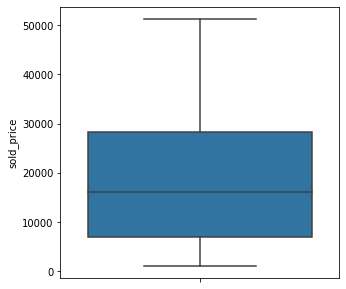

In [15]:
plt.figure(figsize=(5,5))
sns.boxplot(y='sold_price',data=df_raw)

In [16]:
df_raw.sample(10)

,sale_listing_id,sale_id,sale_number,sale_date,sale_week,sale_year,lane_number,branch_id,client_type,seller_account,...,year,make,model,odometer_value,vin,base_colour,body_type_description,derivative,fuel_type_description,transmission_type_description
363058,840750,12453,304,23-Nov-20,48,2020,42,4,Dealer,5468419,...,2017.0,Ford,Super Duty F-250 SRW,117115.0,1FT7W2B67HEE75296,White,Crew Cab Pickup,XLT,Diesel Fuel,A/T
386943,873047,13064,578,06-Apr-21,14,2021,3,1,Dealer,5418824,...,2019.0,Ford,F-150,92174.0,1FTEW1E51KFA89754,Gray,Crew Cab Pickup,XLT,Flex Fuel Capability,A/T
49724,409830,10193,51,0001-01-01 12:00:00.0000000,1,1,0,1,Commercial,4998341,...,2014.0,Volkswagen,Jetta Sedan,99382.0,3VWDL7AJ2EM405271,Black,NaN,NaN,NaN,NaN
322958,834220,12415,510,03-Nov-20,45,2020,10,1,Dealer,5153603,...,2017.0,Ford,F-150,101153.0,1FTFX1EF2HFB56073,White,Extended Cab Pickup,XLT,Gasoline Fuel,A/T
283972,811836,12255,270,06-Aug-20,32,2020,4,4,Commercial,4993477,...,2011.0,FOREST RIV,25RS,1.0,4X4TPUA26BP034531,White,NaN,NaN,NaN,NaN
186998,963877,12462,340,08-Dec-20,50,2020,1,2,Dealer,5217410,...,2015.0,GMC,Sierra 1500,92247.0,3GTU2UEC2FG508691,White,Crew Cab Pickup,SLE,Gasoline Fuel,A/T
132851,631492,11081,318,09-Sep-19,37,2019,5,1,Commercial,4907103,...,2019.0,Dodge,Charger,21072.0,2C3CDXHG6KH595466,Black,NaN,NaN,NaN,NaN
180991,761937,11419,389,10-Feb-20,7,2020,95,1,Commercial,4907104,...,2018.0,Ram,1500,12683.0,1C6RR7UT9JS278287,NaN,Crew Cab Pickup,Night,Gasoline Fuel,A/T
267394,804849,12198,456,14-Jul-20,29,2020,90,1,Commercial,4907104,...,2019.0,Jeep,Compass,13202.0,3C4NJDCB9KT585013,Blue,Sport Utility,Limited,Gasoline Fuel,A/T
314955,822030,12334,389,16-Sep-20,38,2020,2,3,Dealer,5225775,...,2015.0,Chrysler,200,97041.0,1C3CCCAG8FN524112,Black,4dr Car,Limited,Flex Fuel Capability,A/T


In [17]:
df_raw.describe()

,sale_listing_id,sale_id,sale_number,sale_week,sale_year,lane_number,branch_id,sold_price,vehicle_id,year,odometer_value
count,5.549340e+05,554934.000000,554934.000000,554934.000000,554934.000000,554934.000000,554934.000000,554934.000000,554934.000000,554763.000000,554659.000000
mean,8.229993e+05,12528.826210,446.032126,24.615951,2012.947815,20.436679,1.692563,18623.586673,333001.758254,2015.051777,102410.133055
std,1.665190e+05,1214.627669,194.242290,14.466653,123.174839,29.870505,1.020565,13300.729766,109793.912273,4.577492,75027.392566
min,5.400000e+01,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1020.000000,43.000000,0.000000,0.000000
25%,7.729030e+05,11456.000000,316.000000,13.000000,2020.000000,2.000000,1.000000,7000.000000,284645.000000,2013.000000,40289.000000
50%,8.491180e+05,12438.000000,456.000000,22.000000,2020.000000,6.000000,1.000000,16133.000000,351169.000000,2016.000000,88576.000000
75%,9.510085e+05,13699.000000,591.000000,37.000000,2021.000000,25.000000,2.000000,28200.000000,427763.000000,2018.000000,151722.500000
max,1.017571e+06,14169.000000,763.000000,61.000000,2022.000000,99.000000,5.000000,51300.000000,459787.000000,2022.000000,999999.000000


### Outlier removal results
From the Silhouette score, elbow method and CH, outlier removal of sold price gained
0.01 in Silhouette (below), so the clusters are still overlapping.

## Base Colour

Drive Type Description is RWD, AWD, FWD, 4WD. Lexus ES350 is the first
missing its descriptions, so let's find all the others.

Fuel Types are:
Gasoline Fuel, Diesel Fule, Flex Fuel Capability, Natural Gas Fuel,
Gas/Electric Hybrid, Gasoline/Mild Electric Hybrid

**Note: These features (other than _sold price_) are not used in the first iteration,
but we keep them clean anyway**

<AxesSubplot:xlabel='base_colour'>

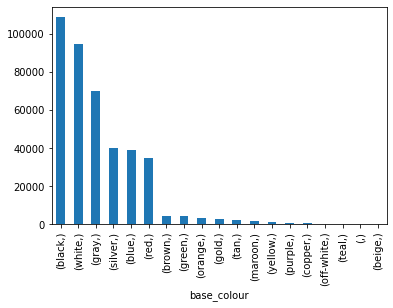

In [16]:
df_clean[['base_colour']].value_counts().plot(kind='bar')

Anything not red, blue, silver, gray/grey, white, black should be combined. Regex
is bad at negative detection, so brute force necessary.

In [10]:
others = {}
df_clean, others['base_colour'] = combine_outliers(df_clean, 'base_colour', 5)

<AxesSubplot:xlabel='base_colour'>

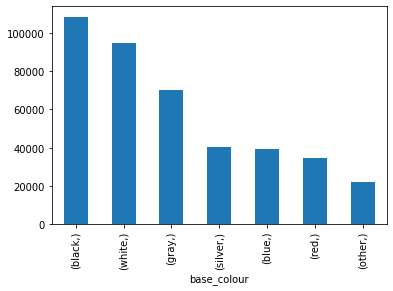

In [11]:
df_clean[['base_colour']].value_counts().plot(kind='bar')

## Body Type Description

body_type_description   
Sport Utility               167239
4dr Car                     119972
Crew Cab Pickup              68757
Mini-van, Passenger          18985
2dr Car                      14287
Extended Cab Pickup          10017
Regular Cab Pickup            3215
Station Wagon                 2956
Full-size Cargo Van           1468
Mini-van, Cargo                911
Full-size Passenger Van        446
3dr Car                        436
Hatchback                      394
Regular Cab Chassis-Cab        114
Crew Cab Chassis-Cab            55
Extended Cab Chassis-Cab        20
Specialty Vehicle               15
dtype: int64


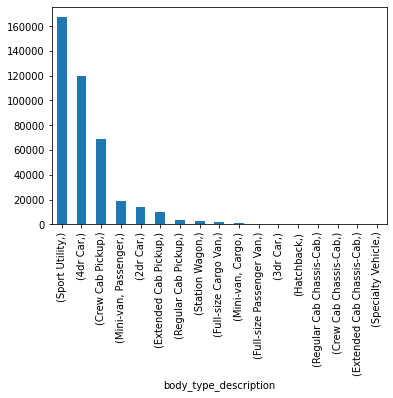

In [12]:
FEATURE = 'body_type_description'
df_clean[[FEATURE]].value_counts().plot(kind='bar')
print(df_clean[[FEATURE]].value_counts())

<AxesSubplot:xlabel='body_type_description'>

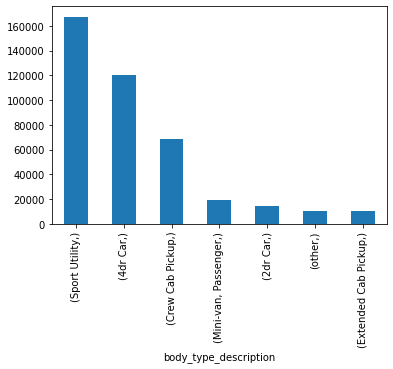

In [13]:
df_clean, others[FEATURE] = combine_outliers(df_clean, FEATURE, 5)
df_clean[[FEATURE]].value_counts().plot(kind='bar')

## Engine Type Description

## Baseline

We will not feature engineer with new categories like "Japanese" or "Rust Bucket in
Grandpa's Garage". The initial dataset is, nonetheless, a baseline by definition.

engine_description                          
4 Cylinder Engine                               193615
V6 Cylinder Engine                              130178
8 Cylinder Engine                                72112
Straight 6 Cylinder Engine                        8124
3 Cylinder Engine                                 2862
5 Cylinder Engine                                 1131
Flat 6 Cylinder Engine                             463
Electric Motor                                     285
6 Cylinder Engine                                  219
10 Cylinder Engine                                 127
12 Cylinder Engine                                  70
Rotary engine                                       40
4.4 L Twin Turbo Premium Unleaded V-8               30
4-cylinder Gas Turbo                                15
6G                                                   9
6-cylinder Gas                                       4
2.0 L Intercooled Turbo Premium Unleaded I-4         3
dtype: int64


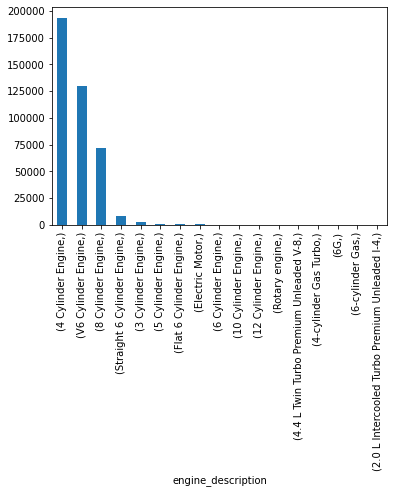

In [14]:
FEATURE = 'engine_description'
df_clean[[FEATURE]].value_counts().plot(kind='bar')
print(df_clean[[FEATURE]].value_counts())

<AxesSubplot:xlabel='engine_description'>

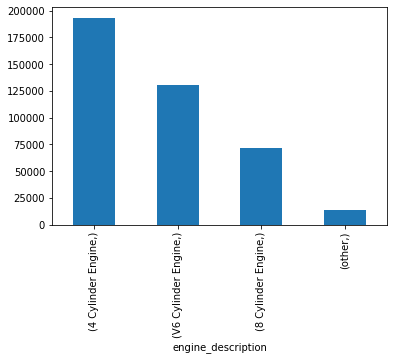

In [15]:
df_clean, others[FEATURE] = combine_outliers(df_clean, FEATURE, 5)
df_clean[[FEATURE]].value_counts().plot(kind='bar')

## Drive Type Description

drive_type_description
Four Wheel Drive          137986
Front Wheel Drive         136754
All Wheel Drive           116539
Rear Wheel Drive           18008
dtype: int64


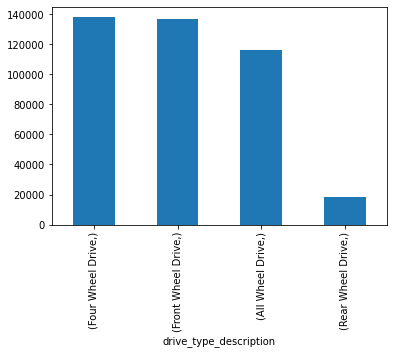

In [16]:
FEATURE = 'drive_type_description'
df_clean[[FEATURE]].value_counts().plot(kind='bar')
print(df_clean[[FEATURE]].value_counts())

No adjustment required for drive type description

In [17]:
# Convert sold price to bins
bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000,
        80000, 90000, 100000, np.inf]
labels = ['<10k', '10-20k', '20-30k', '30-40k', '40-50k', 
          '50-60k', '60-70k', '70-80k', '80-90k', '90-100k', '100k+']
df_clean['price_range'] = pd.cut(df_clean['sold_price'], bins, labels=labels)

## Cool categories
class_categories = ['drive_type_description', 'engine_description',
                   'body_type_description',
                   'base_colour', 'price_range'
                   ]

cluster_data, onehot = create_unsupervised_dataframe(df_clean, class_categories)

In [25]:
cluster_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409287 entries, 0 to 409286
Data columns (total 34 columns):
 #   Column                                     Non-Null Count   Dtype
---  ------                                     --------------   -----
 0   drive_type_description_All Wheel Drive     409287 non-null  int32
 1   drive_type_description_Four Wheel Drive    409287 non-null  int32
 2   drive_type_description_Front Wheel Drive   409287 non-null  int32
 3   drive_type_description_Rear Wheel Drive    409287 non-null  int32
 4   engine_description_4 Cylinder Engine       409287 non-null  int32
 5   engine_description_8 Cylinder Engine       409287 non-null  int32
 6   engine_description_V6 Cylinder Engine      409287 non-null  int32
 7   engine_description_other                   409287 non-null  int32
 8   body_type_description_2dr Car              409287 non-null  int32
 9   body_type_description_4dr Car              409287 non-null  int32
 10  body_type_description_Crew Cab P

In [18]:
df_clean.to_csv('cox_cleaned_binned.csv')

In [26]:
cluster_data.head()

,drive_type_description_All Wheel Drive,drive_type_description_Four Wheel Drive,drive_type_description_Front Wheel Drive,drive_type_description_Rear Wheel Drive,engine_description_4 Cylinder Engine,engine_description_8 Cylinder Engine,engine_description_V6 Cylinder Engine,engine_description_other,body_type_description_2dr Car,body_type_description_4dr Car,...,price_range_20-30k,price_range_30-40k,price_range_40-50k,price_range_50-60k,price_range_60-70k,price_range_70-80k,price_range_80-90k,price_range_90-100k,price_range_<10k,price_range_nan
0,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [27]:
df_clean[['drive_type_description','engine_description','base_colour','sold_price']].head()

,drive_type_description,engine_description,base_colour,sold_price
143,Front Wheel Drive,V6 Cylinder Engine,black,20900
184,Front Wheel Drive,V6 Cylinder Engine,black,20900
207,Front Wheel Drive,V6 Cylinder Engine,silver,23700
215,Front Wheel Drive,V6 Cylinder Engine,silver,23700
279,Front Wheel Drive,4 Cylinder Engine,white,7800


## KMeans

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

### Determine best number of clusters from Silhouette and Calinksi-Harabasz

In [33]:
def compare_cluster_results(
    data:pd.DataFrame, max_iterations:int, n_init:int, max_n_clusters:int
)-> list[list]:
    """Create WCSS, Silhouette and CH score comparison lists"""
    wcss_comparisons = []
    silhouette_score_comparisons = []
    c_h_comparisons = []

    for n_clusters in tqdm.tqdm(range(2, max_n_clusters+1)):  # tqdm = prog. bar
        km_model = KMeans(
            n_clusters=n_clusters,
            max_iter=max_iterations,
            n_init=n_init,
            random_state=RANDOM_STATE
        ).fit(data)
        wcss_comparisons.append(km_model.inertia_)
        silhouette_score_comparisons.append(
            silhouette_score(
                data, km_model.labels_, random_state=RANDOM_STATE
            )
        )
        c_h_comparisons.append(calinski_harabasz_score(data, km_model.labels_))

    return wcss_comparisons, silhouette_score_comparisons, c_h_comparisons

In [34]:
MAX_ITERATIONS = 100  # Number of runs to tighten centroids
N_INIT = 10  # Number of iterations with differing centroid seeds
MAX_N_CLUSTERS = 20

wcss, silhouette, calinski_harabasz = compare_cluster_results(
    cluster_data, MAX_ITERATIONS, N_INIT, MAX_N_CLUSTERS
)

100%|██████████| 19/19 [8:17:41<00:00, 1571.65s/it]  


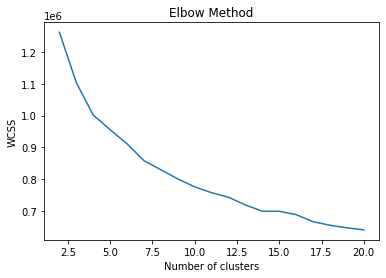

In [35]:
## Elbow method
plt.plot(range(2, MAX_N_CLUSTERS+1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

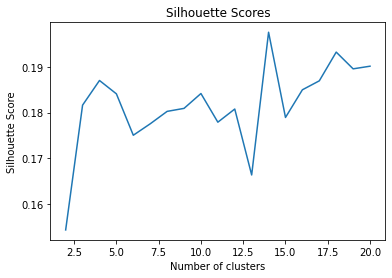

In [36]:
## Silhouette Score
plt.plot(range(2, MAX_N_CLUSTERS+1), silhouette)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

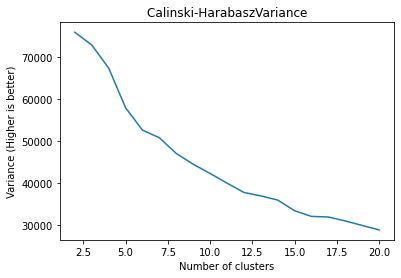

In [37]:
## Calinski-Harabasz Variance
plt.plot(range(2, MAX_N_CLUSTERS+1), calinski_harabasz)
plt.title('Calinski‐Harabasz Variance')
plt.xlabel('Number of clusters')
plt.ylabel('Variance (Higher is better)')
plt.show()

## Results
1. There is an elbow at 14 clusters
2. Silhouette shows just under 0.2 for 14 clusters. There is definitely overlap, but
   not as bad as previous attempts.
3. CH prefers two clusters, which just isn't going to happen

# D. Production Model

Business requirement is to display ~50 vehicles per buyer out of 500 vehicles. Buyer
preferences will overlap. Going for seven or eight clusters.

From Using price, colour, car details but not make. Previous experiments showed
imbalance on fuel types, so this will be fuel-agnostic.

In [29]:
N_CLUSTERS = 14  # Business requirements are 20, but let's see what 14 does.
MAX_ITERATIONS = 300  # Tighten the centroids
N_INIT = 10

In [30]:
km_model = KMeans(
    n_clusters=N_CLUSTERS,
    max_iter=MAX_ITERATIONS,
    n_init=N_INIT,
    random_state=RANDOM_STATE
).fit(cluster_data)

In [31]:
pd.DataFrame(data=km_model.labels_).isnull().any()

0    False
dtype: bool

## Inspect the clusters

In [32]:
results = cluster_data.join(
    pd.DataFrame(columns=['cluster'], data=km_model.labels_)
)

In [33]:
results.head()

,drive_type_description_All Wheel Drive,drive_type_description_Four Wheel Drive,drive_type_description_Front Wheel Drive,drive_type_description_Rear Wheel Drive,engine_description_4 Cylinder Engine,engine_description_8 Cylinder Engine,engine_description_V6 Cylinder Engine,engine_description_other,body_type_description_2dr Car,body_type_description_4dr Car,...,price_range_30-40k,price_range_40-50k,price_range_50-60k,price_range_60-70k,price_range_70-80k,price_range_80-90k,price_range_90-100k,price_range_<10k,price_range_nan,cluster
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6
4,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,2


In [34]:
for i in range(N_CLUSTERS):
    mask = (results['cluster'] == i)
    values = results.loc[mask].mean()
    mask2 = (values > 0.05)
    print(f"\n## Cluster {i}")
    print(values[mask2])


## Cluster 0
drive_type_description_Rear Wheel Drive      0.984773
engine_description_4 Cylinder Engine         0.101861
engine_description_8 Cylinder Engine         0.420687
engine_description_V6 Cylinder Engine        0.288606
engine_description_other                     0.188845
body_type_description_2dr Car                0.419345
body_type_description_4dr Car                0.194738
body_type_description_Extended Cab Pickup    0.091418
body_type_description_other                  0.246835
base_colour_black                            0.143224
base_colour_blue                             0.063415
base_colour_gray                             0.109737
base_colour_red                              0.099819
base_colour_silver                           0.073625
base_colour_white                            0.464792
price_range_10-20k                           0.105828
price_range_20-30k                           0.162593
price_range_30-40k                           0.144974
price_range_40

## Personas

See buyer_lookup in the [Recommender Engine](#Recommender-Engine) portion for some
examples had the buyers been retail. However, according to the product owner, the
personas might not be valuable. Nevertheless, the team brought it to the product
owner's attention for future discussion.

### Save the data that will be required for the recommender engine.

In [35]:
# Save training specs and trained models for prediction
import pickle
pickle.dump(
    km_model,
    open(os.path.join(SCRIPT_DIR, 'km_model.pkl'), 'wb')
)
pickle.dump(
    onehot,
    open(os.path.join(SCRIPT_DIR, 'onehotencoder.pkl'), 'wb')
)
pickle.dump(
    df_clean,
    open(os.path.join(SCRIPT_DIR, 'cleandata.pkl'), 'wb')
)
pickle.dump(
    SANITIZE_DATA,
    open(os.path.join(SCRIPT_DIR, 'sanitization_spec.pkl'), 'wb')
)
pickle.dump(
    class_categories,
    open(os.path.join(SCRIPT_DIR, 'class_categories.pkl'), 'wb')
)
pickle.dump(
    (bins, labels),
    open(os.path.join(SCRIPT_DIR, 'bins.pkl'), 'wb')
)
pickle.dump(
    others,
    open(os.path.join(SCRIPT_DIR, 'others.pkl'), 'wb')
)

# E. Recommender Engine

Wherein we load the data structures used in training that must be reused for
production.

Do not forget to load cell 1 and cell 3!!


The recommender engine is based on "collaborative filtering," of which ALS is an
example. See [ALS](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1).
We are somewhat reinventing the wheel here.

  1. Create a lookup table with two features: buyer and cluster, from the training 
     labels.
  2. Create a clean target (i.e. current inventory) dataframe with all features
  3. From the clean target, create a prediction featureset with the same features
     used in training.
  4. Feed the prediction featureset into the model and return predictions.
  5. Add the predictions to the clean target (call the result the "inventory").
  6. From buyer history in the lookup table and the inventory, make recommendations.
  7. ...
  8. Profit!

In [12]:
import os
import pickle
import re

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


N_CLUSTERS = 14  # This is a business decision informed by elbow/silhouette.



SCRIPT_DIR = os.path.abspath('')
CSVFILE = 'cox_vehicle_info.csv'
TEST_SPLIT = 25  # in percent
RANDOM_STATE = 42  # Life, the Universe and Everything
MODEL_FILENAME = 'km_model.pkl'
ENCODER_FILENAME = 'onehotencoder.pkl'
CLEAN_ORIGINAL_DATA_FILENAME = 'cleandata.pkl'
SANITIZE_SPEC_FILENAME = 'sanitization_spec.pkl'
CLASS_CATEGORIES_FILENAME = 'class_categories.pkl'
NUMERIC_CATEGORIES_FILENAME = 'numeric_categories.pkl'
BINS_FILENAME = 'bins.pkl'
OTHERS_FILENAME = 'others.pkl'

km_model = pickle.load(
    open(os.path.join(SCRIPT_DIR, MODEL_FILENAME), 'rb')
)
onehot = pickle.load(
    open(os.path.join(SCRIPT_DIR, ENCODER_FILENAME), 'rb')
)
orig_clean_data = pickle.load(
    open(os.path.join(SCRIPT_DIR, CLEAN_ORIGINAL_DATA_FILENAME), 'rb')
)
sanitization_specs = pickle.load(
    open(os.path.join(SCRIPT_DIR, SANITIZE_SPEC_FILENAME), 'rb')
)
class_categories = pickle.load(
    open(os.path.join(SCRIPT_DIR, CLASS_CATEGORIES_FILENAME), 'rb')
)
bins, labels = pickle.load(
    open(os.path.join(SCRIPT_DIR, BINS_FILENAME), 'rb')
)

# "Others" are categories where a subset of values are renamed 'other' to deal
# with balance issues.
others = pickle.load(
    open(os.path.join(SCRIPT_DIR, OTHERS_FILENAME), 'rb')
)

## Buyer Lookup (Collaborative Filtering Component)

In [13]:
# Add the cluster id's to the original, cleaned data
buyer_lookup = orig_clean_data[['buyer_account']].copy()
buyer_lookup['cluster'] = km_model.labels_
buyer_lookup.head()

,buyer_account,cluster
143,5244859,6
184,5244859,6
207,5224568,6
215,5224568,6
279,5358707,2


In [14]:
# Feed the new auction car specs
NEW_AUCTION_CSV_FILE = 'cox_vehicle_july_target.csv'
df_raw = load_data(NEW_AUCTION_CSV_FILE)
clean_column_names(df_raw)
df_raw = df_raw.rename(columns={'clientt_type': 'client_type'})
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   sale_listing_id                  367 non-null    int64  
 1   listing_state                    367 non-null    object 
 2   sale_name                        367 non-null    object 
 3   sale_id                          367 non-null    int64  
 4   sale_number                      367 non-null    int64  
 5   sale_date                        367 non-null    object 
 6   sale_week                        367 non-null    int64  
 7   sale_year                        367 non-null    int64  
 8   lane_number                      367 non-null    int64  
 9   branch_id                        367 non-null    int64  
 10  branch                           367 non-null    object 
 11  client_type                      367 non-null    object 
 12  seller_account        

### Notes on the target data

Yuck. The features we want are either ".1" or not. Fix it!

In [15]:
pred_df_preclean = df_raw[['sale_listing_id', 'make', 'model',
                           'year_of_manufacture.1',
                           'drive_type_description', 'engine_description.1',
                           'body_type_description', 'base_colour.1',
                           'branch_id', 'odometer_value', 'sold_price']]
pred_df_preclean = pred_df_preclean.rename(
    columns={'engine_description.1': 'engine_description',
             'base_colour.1': 'base_colour',
             'year_of_manufacture.1': 'year_of_manufacture'}
)
pred_df_clean = sanitize(pred_df_preclean, sanitization_specs)
pred_df_clean = clean_features(pred_df_clean, ['base_colour'])
pred_df_clean

,sale_listing_id,make,model,year_of_manufacture,drive_type_description,engine_description,body_type_description,base_colour,branch_id,odometer_value,sold_price
0,1023890,BMW,X6,2016,All Wheel Drive,Straight 6 Cylinder Engine,Sport Utility,black,1,181027,26750
1,1024922,GMC,Savana Cargo Van,2019,Rear Wheel Drive,8 Cylinder Engine,Full-size Cargo Van,white,1,26416,49500
2,1024126,Ford,Edge,2017,All Wheel Drive,4 Cylinder Engine,Sport Utility,black,1,26417,23300
3,1024945,GMC,Sierra 1500,2014,Four Wheel Drive,8 Cylinder Engine,Crew Cab Pickup,white,4,70052,21250
4,1024316,GMC,Savana Passenger,2016,Rear Wheel Drive,8 Cylinder Engine,Full-size Passenger Van,white,1,70053,30000
...,...,...,...,...,...,...,...,...,...,...,...
361,1024202,Ford,Super Duty F-250 SRW,2020,Four Wheel Drive,8 Cylinder Engine,Crew Cab Pickup,red,1,113914,91000
362,1023105,Nissan,Rogue,2018,All Wheel Drive,4 Cylinder Engine,Sport Utility,red,2,113915,30000
363,1024598,Mitsubishi,RVR,2018,Four Wheel Drive,4 Cylinder Engine,Sport Utility,black,1,58655,18800
364,1023531,Toyota,Camry,2010,Front Wheel Drive,4 Cylinder Engine,4dr Car,green,1,138783,3800


In [16]:
# Colour gave us trouble when training. Double check.

pred_df_clean['base_colour'].value_counts()

black     95
white     82
gray      43
silver    35
red       35
blue      25
green      8
orange     4
yellow     2
brown      2
purple     1
tan        1
Name: base_colour, dtype: int64

In [17]:
## Any category that is horribly unbalanced is named other
for feature, values in others.items():
    for value in values:
        pred_df_clean[feature].replace(value, 'other', inplace=True)
pred_df_clean

,sale_listing_id,make,model,year_of_manufacture,drive_type_description,engine_description,body_type_description,base_colour,branch_id,odometer_value,sold_price
0,1023890,BMW,X6,2016,All Wheel Drive,other,Sport Utility,black,1,181027,26750
1,1024922,GMC,Savana Cargo Van,2019,Rear Wheel Drive,8 Cylinder Engine,other,white,1,26416,49500
2,1024126,Ford,Edge,2017,All Wheel Drive,4 Cylinder Engine,Sport Utility,black,1,26417,23300
3,1024945,GMC,Sierra 1500,2014,Four Wheel Drive,8 Cylinder Engine,Crew Cab Pickup,white,4,70052,21250
4,1024316,GMC,Savana Passenger,2016,Rear Wheel Drive,8 Cylinder Engine,other,white,1,70053,30000
...,...,...,...,...,...,...,...,...,...,...,...
361,1024202,Ford,Super Duty F-250 SRW,2020,Four Wheel Drive,8 Cylinder Engine,Crew Cab Pickup,red,1,113914,91000
362,1023105,Nissan,Rogue,2018,All Wheel Drive,4 Cylinder Engine,Sport Utility,red,2,113915,30000
363,1024598,Mitsubishi,RVR,2018,Four Wheel Drive,4 Cylinder Engine,Sport Utility,black,1,58655,18800
364,1023531,Toyota,Camry,2010,Front Wheel Drive,4 Cylinder Engine,4dr Car,other,1,138783,3800


## July Auction Inventory, One Hot

In [18]:
# Put the sold price into bins, just like in training
pred_df_clean['price_range'] = pd.cut(
    pred_df_clean['sold_price'], bins, labels=labels
)

pred_df = create_prediction_dataframe(pred_df_clean, onehot, class_categories)
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   drive_type_description_All Wheel Drive     333 non-null    int32
 1   drive_type_description_Four Wheel Drive    333 non-null    int32
 2   drive_type_description_Front Wheel Drive   333 non-null    int32
 3   drive_type_description_Rear Wheel Drive    333 non-null    int32
 4   engine_description_4 Cylinder Engine       333 non-null    int32
 5   engine_description_8 Cylinder Engine       333 non-null    int32
 6   engine_description_V6 Cylinder Engine      333 non-null    int32
 7   engine_description_other                   333 non-null    int32
 8   body_type_description_2dr Car              333 non-null    int32
 9   body_type_description_4dr Car              333 non-null    int32
 10  body_type_description_Crew Cab Pickup      333 non

## Predict!

In [19]:
predictions = km_model.predict(pred_df)
predictions

array([ 5,  0,  5,  4,  0,  1,  1,  4, 11,  4,  5,  4,  1,  1,  7,  2,  6,
        7,  5,  3,  2,  4, 13, 11,  3,  7,  8, 10,  1,  8,  3,  4,  6,  5,
        2, 11,  5,  0,  8,  2,  8,  8, 12,  5,  0,  4,  8,  5,  3,  5,  9,
        5,  3,  0, 13, 10,  4,  5,  4,  8,  4,  5,  5,  7, 13,  0,  4, 12,
        4,  7,  4,  3,  4,  8,  8,  8,  0,  0,  5,  8, 11,  3,  5,  6,  9,
        3,  0, 10,  6,  6,  7, 13,  5, 10, 10,  1,  8,  3,  6, 10,  0,  6,
        3,  6,  5, 10,  5,  4,  1,  8, 13, 10,  6, 11,  7, 10,  1,  5,  2,
        7,  6,  7, 10, 10,  3,  2,  9,  3,  1,  7,  3,  3,  5,  1, 12,  1,
        7, 11, 13,  7,  8, 13,  4,  4,  4,  0,  8,  4,  2, 12,  4, 10,  4,
        1,  7,  2,  1,  1, 12, 12, 12, 12, 12,  5,  5,  1,  4, 13,  5,  2,
        1,  1,  5,  5,  2,  5,  3,  5,  6,  3, 11, 11,  0,  3, 11,  5,  3,
       13,  7,  3,  0,  4, 12,  8,  9,  5,  5,  8, 13,  6,  0,  4, 13, 13,
       13,  4,  3,  1, 10, 10,  4,  5,  2,  0,  3,  1,  3,  4,  0,  0,  2,
       12, 13,  0,  7,  1

## Add Clusters to the Inventory
Original data, cleaned + cluster

In [20]:
inventory = pred_df_clean
inventory['cluster'] = predictions
inventory['cluster'].value_counts()

4     44
5     43
1     34
3     29
8     25
0     22
7     22
10    21
6     19
13    19
2     18
11    14
12    14
9      9
Name: cluster, dtype: int64

### Whither the value count?

The value counts indicate that 14 categories is not only a non-overfitted "elbow"
target, but also a good business target. It means that no car will be left behind
if 50 cars are the selection to be sent to the buyer.

Since the business decided on a sample of 50 cars to be sent to each buyer, had any
cluster more than 50 cars (say, 56), then six of those cars would risk never being
picked up.

In [21]:
def recommend(
    inventory: pd.DataFrame, buyer_lookup: pd.DataFrame,
    buyer_id: str, stop=50)-> pd.DataFrame:
    """Recommend the vehicles most likely to match the buyer's profile"""

    sorted_buyer_profile = create_ordered_buyer_profile(buyer_lookup, buyer_id) 
    recommendations = None

    i = 0
    for key, count in sorted_buyer_profile.items():
        if i >= stop:
            break
        if count <= 0:  # No point in always giving cluster 0
            continue
        tmppd = inventory[inventory['cluster'] == key]
        if recommendations is None:  # Initialize the results dataframe
            recommendations = tmppd.copy()
        else:
            recommendations = pd.concat([recommendations, tmppd.copy()])
        i = len(recommendations)

    return recommendations.head(stop)

def create_ordered_buyer_profile(buyer_lookup, buyer_id):
    """Creates a list of clusters in order of cluster popularity"""
    buyer_profile = {}

    for i in range(N_CLUSTERS):
        mask = (buyer_lookup['buyer_account'] == buyer_id) & \
               (buyer_lookup['cluster'] == i)
        buyer_profile[i] = len(buyer_lookup[mask])

    return {k: v for k, v in sorted(
        buyer_profile.items(), key=lambda item: item[1],
        reverse=True
    )}

## Engine Complete: Test

In [22]:
## Test. Which clusters does buyer 5244859 like the most?
mask = buyer_lookup['buyer_account'] == '5244859'  # str, not int
buyer_lookup[mask].value_counts()

buyer_account  cluster
5244859        13         25
               5           2
               6           2
dtype: int64

## Persona
Looks like our friend 5244859 bought 29 vehicles in the last seven years. He or she
likes cluster 13 most of all, followed by cluster 5 and 6. If the recommendation
engine works properly, the list will show cluster 13, followed by 5 and 6.

Cluster 13 is AWD 4-door cars, mixed engine and prices.

Cluster 5 is 4-banger FWD SUV's, which I didn't know was a thing. Cluster 6 is
inexpensive FWD cars, tending towards minivans.

In [23]:
recommend(inventory, buyer_lookup, '5244859', 50)

,sale_listing_id,make,model,year_of_manufacture,drive_type_description,engine_description,body_type_description,base_colour,branch_id,odometer_value,sold_price,price_range,cluster
25,1023549,Mercedes-Benz,C-Class,2018,All Wheel Drive,4 Cylinder Engine,4dr Car,black,1,17654,28500,20-30k,13
66,1023775,Tesla,Model S,2015,All Wheel Drive,other,4dr Car,gray,2,36983,52800,50-60k,13
76,1023175,INFINITI,Q50,2017,All Wheel Drive,V6 Cylinder Engine,4dr Car,black,2,117189,29100,20-30k,13
105,1024551,Volkswagen,Golf R,2017,All Wheel Drive,4 Cylinder Engine,4dr Car,white,1,77245,34500,30-40k,13
127,1023534,Lexus,IS 250,2007,All Wheel Drive,V6 Cylinder Engine,4dr Car,silver,1,56472,10000,<10k,13
156,1024165,Subaru,Impreza,2010,All Wheel Drive,4 Cylinder Engine,4dr Car,black,2,28986,2700,<10k,13
159,1024829,Audi,A5 Sportback,2020,All Wheel Drive,4 Cylinder Engine,4dr Car,black,1,182835,53000,50-60k,13
187,1023167,Audi,A4,2017,All Wheel Drive,4 Cylinder Engine,4dr Car,black,2,92728,22600,20-30k,13
207,1023550,BMW,5 Series Gran Turismo,2011,All Wheel Drive,other,4dr Car,black,1,126108,11100,10-20k,13
219,1023271,Acura,TLX,2015,All Wheel Drive,V6 Cylinder Engine,4dr Car,black,1,11929,13400,10-20k,13


In [24]:
BUYER = '5462526'
mask = buyer_lookup['buyer_account'] == BUYER  # str, not int
buyer_lookup[mask].value_counts()

buyer_account  cluster
5462526        4          108
               2           90
               7           66
               10          41
               8           31
               3           30
               12          28
               0           24
               5           18
               6           14
               13          12
               9            7
dtype: int64

Wow, this buyer buys a lot, and he is all over the map. Clusters 4, 2, 7 but also 10, 8, 3...

## Persona

This dealer hits 12 of the 14 clusters and is balanced compared to our previous buyer.

He avoids clusters 1 (cheap front-wheel-drive 4-bangers) and 11 (cheap AWD 4-bangers,
tendency of 4-door and SUVs).

In [25]:
recommend(inventory, buyer_lookup, BUYER, 50)

,sale_listing_id,make,model,year_of_manufacture,drive_type_description,engine_description,body_type_description,base_colour,branch_id,odometer_value,sold_price,price_range,cluster
3,1024945,GMC,Sierra 1500,2014,Four Wheel Drive,8 Cylinder Engine,Crew Cab Pickup,white,4,70052,21250,20-30k,4
8,1023831,Chevrolet,Silverado 1500,2015,Four Wheel Drive,8 Cylinder Engine,Extended Cab Pickup,black,1,115332,26500,20-30k,4
11,1024942,Ram,1500,2017,Four Wheel Drive,8 Cylinder Engine,Crew Cab Pickup,gray,4,72523,14500,10-20k,4
13,1023879,Ram,1500,2017,Four Wheel Drive,8 Cylinder Engine,Crew Cab Pickup,black,1,181253,37250,30-40k,4
24,1024615,Chevrolet,Silverado 1500 LD,2019,Four Wheel Drive,8 Cylinder Engine,Extended Cab Pickup,silver,4,50470,27100,20-30k,4
36,1023674,Chevrolet,Silverado 2500HD,2020,Four Wheel Drive,8 Cylinder Engine,Crew Cab Pickup,silver,1,76927,58000,50-60k,4
57,1024764,Ram,1500,2018,Four Wheel Drive,8 Cylinder Engine,Crew Cab Pickup,blue,1,90,46000,40-50k,4
68,1023815,Ford,Super Duty F-450 DRW,2020,Four Wheel Drive,8 Cylinder Engine,Crew Cab Pickup,white,1,37524,85000,80-90k,4
70,1023809,GMC,Sierra 2500HD,2021,Four Wheel Drive,8 Cylinder Engine,Crew Cab Pickup,black,1,22595,90500,90-100k,4
72,1023597,Chevrolet,Silverado 1500,2011,Four Wheel Drive,8 Cylinder Engine,Crew Cab Pickup,other,1,23402,9000,<10k,4


Categories 0, 8 etc are not represented since there are so many cars in the first three.
This buyer loves buying and his results should trigger a flag. Either up the recommendations or
perhaps the business should take this one to an expensive lunch.

# F. Demonstration
### Collaborative Filtering Recommender Engine
  - Ensure cell 1 and 3 and the cells between "Recommender Engine" and
    "Engine Complete:Test" have been executed.
  - This is a POC/MVP not to be demonstrated outside Mannheim or MMAI internal.
  - Once customer target data is standardized, this notebook will be converted to
    production code.

In [33]:
# Keeping the demo honest. Look up a *random* buyer
buyer_lookup[['buyer_account']].sample()

,buyer_account
198861,5330820


In [34]:
BUYER = '5330820'
recommend(inventory, buyer_lookup, BUYER, 50)

,sale_listing_id,make,model,year_of_manufacture,drive_type_description,engine_description,body_type_description,base_colour,branch_id,odometer_value,sold_price,price_range,cluster
6,1022268,Volkswagen,Jetta,2019,Front Wheel Drive,4 Cylinder Engine,4dr Car,gray,1,152475,23400,20-30k,1
7,1024192,Toyota,Corolla,2017,Front Wheel Drive,4 Cylinder Engine,4dr Car,silver,1,115331,19500,10-20k,1
14,1024921,Volkswagen,Golf GTI,2018,Front Wheel Drive,4 Cylinder Engine,4dr Car,gray,1,181254,24850,20-30k,1
15,1023663,Chevrolet,Cruze,2018,Front Wheel Drive,4 Cylinder Engine,4dr Car,blue,1,11164,22500,20-30k,1
32,1025052,Volkswagen,Jetta,2019,Front Wheel Drive,4 Cylinder Engine,4dr Car,white,4,53615,15500,10-20k,1
109,1023038,Chrysler,200,2015,Front Wheel Drive,V6 Cylinder Engine,4dr Car,black,2,25220,13500,10-20k,1
123,1024995,Kia,Soul,2018,Front Wheel Drive,4 Cylinder Engine,4dr Car,red,3,151676,17100,10-20k,1
133,1023498,Volkswagen,Golf,2015,Front Wheel Drive,4 Cylinder Engine,4dr Car,black,2,15138,12100,10-20k,1
145,1023062,Volkswagen,Golf,2016,Front Wheel Drive,4 Cylinder Engine,4dr Car,black,2,93024,12600,10-20k,1
151,1024554,Nissan,Micra,2019,Front Wheel Drive,4 Cylinder Engine,4dr Car,gray,2,182834,17000,10-20k,1


In [35]:
mask = buyer_lookup['buyer_account'] == BUYER  # str, not int
buyer_lookup[mask].value_counts()

buyer_account  cluster
5330820        1          332
               11         299
               2          221
               5          211
               7           80
               0           75
               4           69
               13          37
               10          36
               3           28
               6           26
               8           11
               9           10
               12           3
dtype: int64